In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os 
import sys 
import re
from tqdm import tqdm
from joblib import Parallel, delayed

/home/daiwei/miniconda3/envs/rlhf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
grid_search_fileNames = os.listdir('./save_samplesize/')
grid_search_filePaths = [os.path.join('./save_samplesize/',i) for i in grid_search_fileNames]

In [3]:
train_stats_samples_all = []

def tmp_fun(filePath):
    res = torch.load(filePath)
    return({**res['args'], 'test_accu_record': res['train_stats']['test_accu_record']})

train_stats_samples_all = Parallel(n_jobs=32)(delayed(tmp_fun)(i) for i in tqdm(grid_search_filePaths))

100%|██████████| 27/27 [00:00<00:00, 2270.78it/s]


In [23]:
samplesize = []
final_test_accu = []
for i in train_stats_samples_all:
    samplesize.append(i['num_pairs_per_user'])
    final_test_accu.append(i['test_accu_record'][-1])

In [24]:
samplesize, final_test_accu = list(zip(*sorted(zip(samplesize,final_test_accu))))

Text(0.5, 1.0, 'Color Preference Prediction Accuracy')

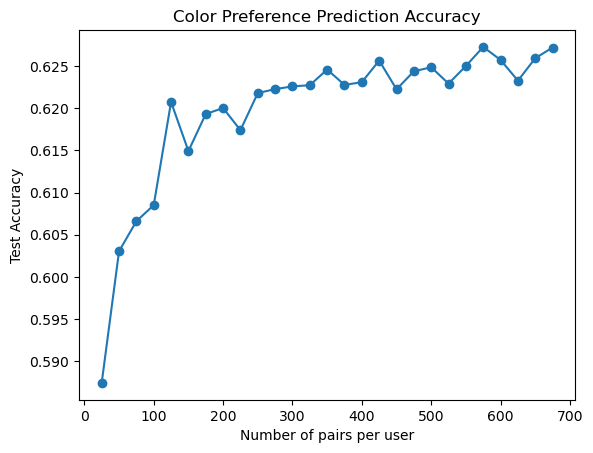

In [25]:
fig,ax = plt.subplots()
ax.plot(samplesize,final_test_accu, '-o')
ax.set_xlabel('Number of pairs per user')
ax.set_ylabel('Test Accuracy')
ax.set_title('Color Preference Prediction Accuracy')

# Metric singular value check

In [4]:
grid_search_fileNames = os.listdir('./save_samplesize/')
grid_search_filePaths = [os.path.join('./save_samplesize/',i) for i in grid_search_fileNames]
res_list = [torch.load(filePath) for filePath in tqdm(grid_search_filePaths)]

100%|██████████| 27/27 [05:03<00:00, 11.25s/it]


In [8]:
sample_size = []
final_test_accu = []
final_relative_metric_error = []
final_relative_ideal_point_error = []
final_learner = []
for i in res_list:
    sample_size.append(i['args']['num_pairs_per_user'])
    final_test_accu.append(i['train_stats']['test_accu_record'][-1])
    # final_relative_metric_error.append(i['train_stats']['relative_metric_error_record'][-1])
    # final_relative_ideal_point_error.append(i['train_stats']['relative_ideal_point_error_record'][-1])
    final_learner.append(i['learner'])

In [9]:

pred_M_list = []
pred_U_list = []
singular_list = []

for i in final_learner:
    pred_L = i.model.layers.weight.detach().numpy()
    pred_M_list.append(pred_L.T @ pred_L)
    pred_U_list.append(i.us.detach().numpy())
    U, S, Vh = np.linalg.svd(pred_L.T @ pred_L)
    singular_list.append(S)

In [10]:
sample_size,final_test_accu, final_learner = list(zip(*sorted(zip(sample_size,final_test_accu,final_learner))))

Text(0.5, 1.0, 'The singular values of $\\hat{M}$ with different num_pairs_per_user (Color dataset)')

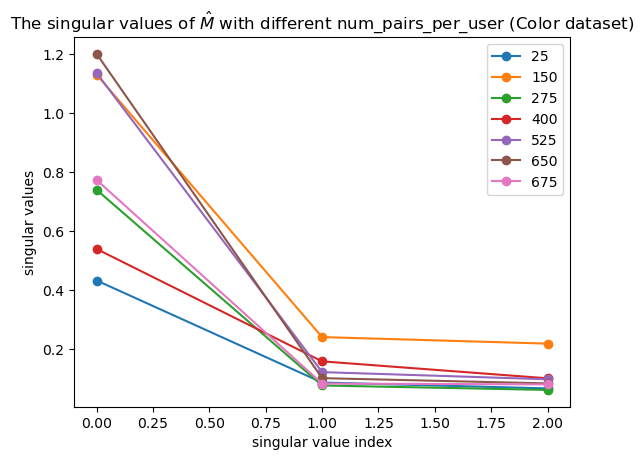

In [14]:
fig,ax = plt.subplots()

for i in [0,5,10,15,20,25,-1]:
    ax.plot(np.array(singular_list)[i,:],'-o',label=sample_size[i])
ax.legend()

ax.set_xlabel('singular value index')
ax.set_ylabel('singular values')
ax.set_title('The singular values of $\hat{M}$ with different num_pairs_per_user (Color dataset)')

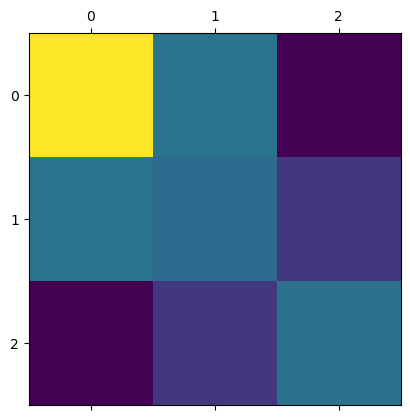

In [15]:
plt.matshow(pred_M_list[-1])